In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate
import seaborn as sns
from typing import List

from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

In [3]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

In [4]:
df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'},inplace=True)

/tmp/ipykernel_25770/3160726128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'},inplace=True)


## Statistical (Econometric) Models

In [5]:
# select models to test:

models = [
    AutoARIMA(season_length=12),
    HoltWinters(),
    #Croston(),
    #SeasonalNaive(season_length=12),
    #HistoricAverage(),
    #DOT(season_length=24)
]

In [6]:
# Instantiate StatsForecast class as sf:

sf = StatsForecast(
    df=df_nixtla, # df with specific columns
    models=models,  # selected models 
    freq='MS', # frequency denotes the granularity of the data. M for months in this case
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=12)
)

In [7]:
# make

forecasts_df = sf.forecast(h=12, # number of steps
                           level=[90] #  this optional parameter is used for probabilistic forecasting. 
                                      #  90 means that the model expects the real value to be inside that interval 90% of the times
                          )

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:1908: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(
/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:896: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(res)
/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:896: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(res)
/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:896: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(res)
/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:896: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(res)
/home/jan_rathfelder/Development/env_basic/lib/

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


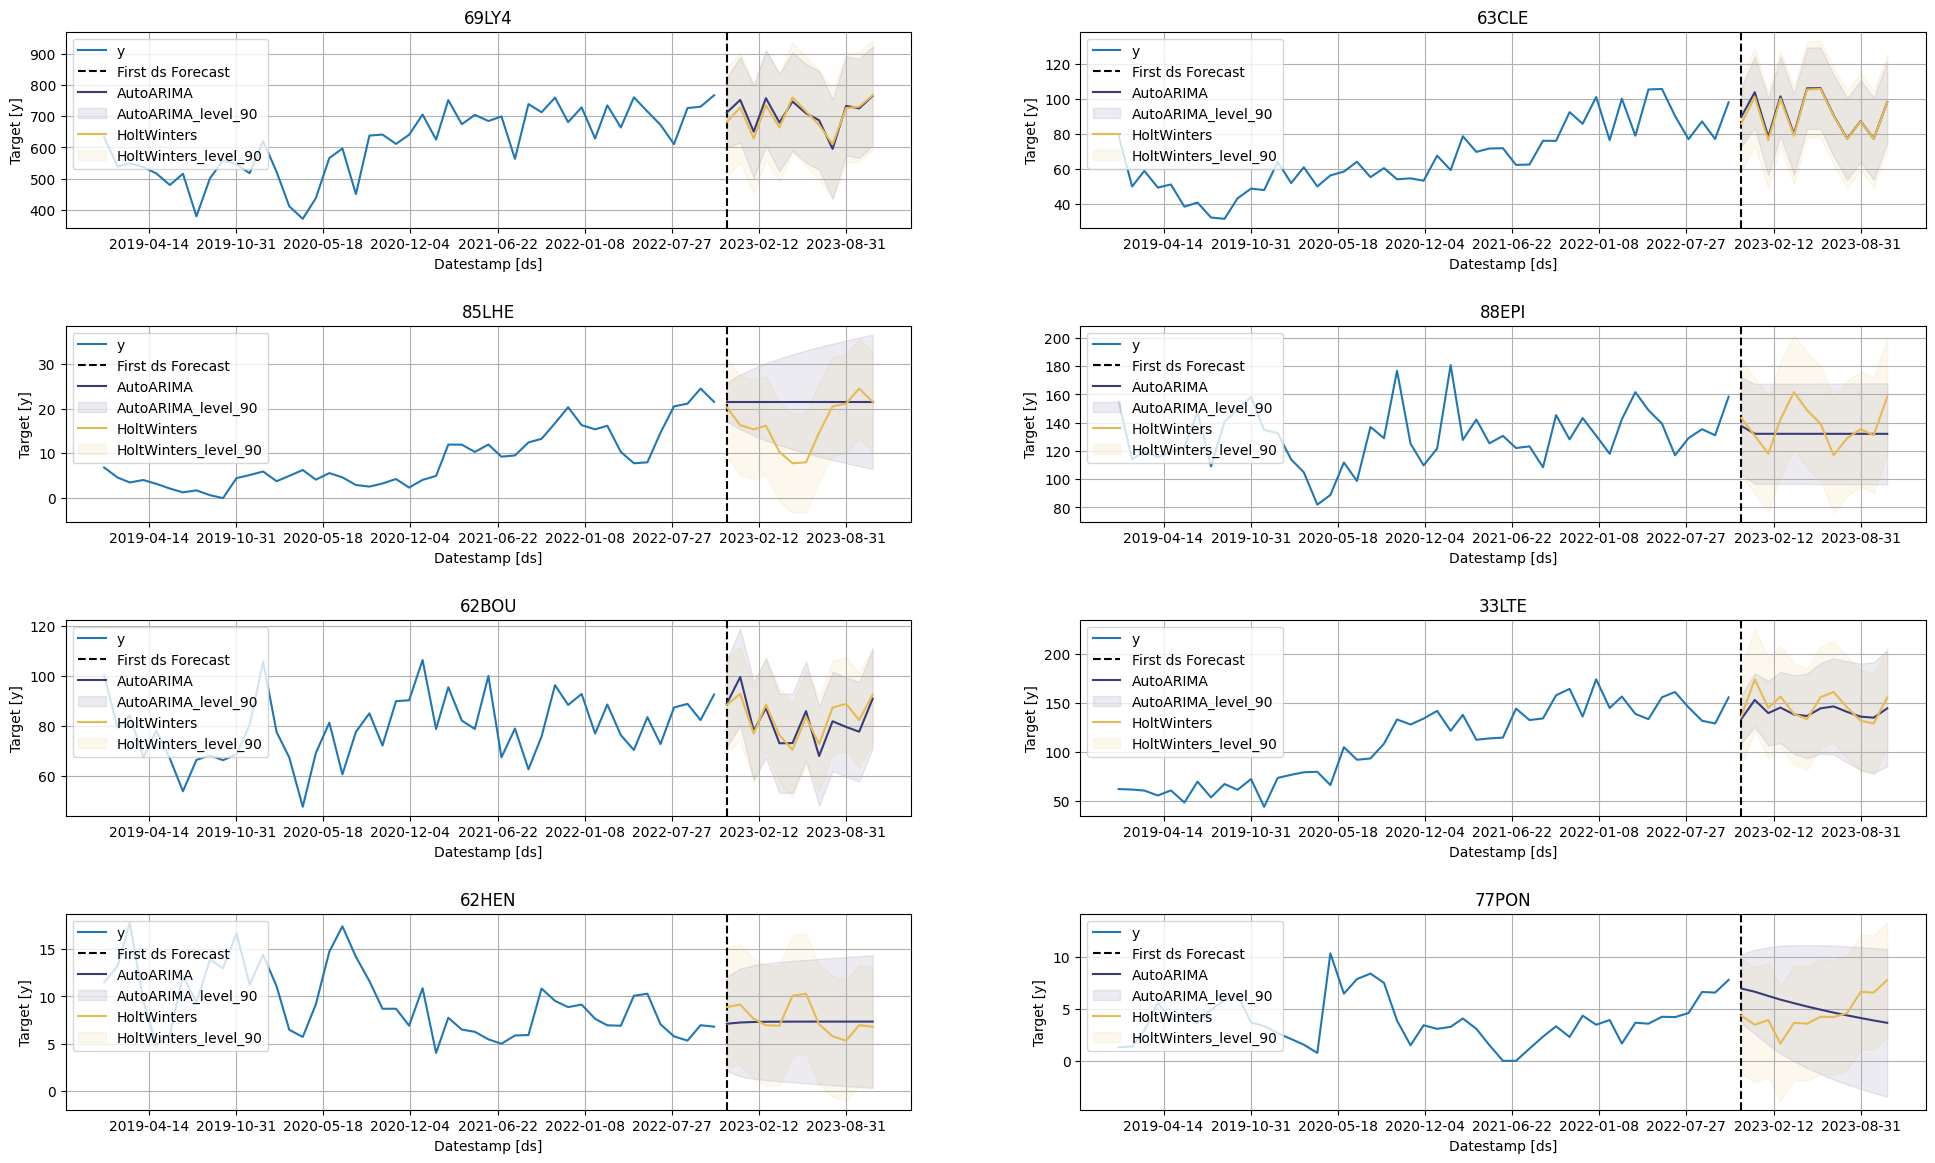

In [8]:
# plot 8 random examples:

sf.plot(df_nixtla,
        forecasts_df, 
        engine='matplotlib')

In [9]:
# apply ts-cross-validation:

crossvaldation_df = sf.cross_validation(
    df=df_nixtla,
    h=4, # represents h steps into the future that are being forecasted
    step_size=4, #  step size between each window. In other words: how often do you want to run the forecasting processes
    n_windows=2 #  number of windows used for cross validation
  )

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:1908: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(
/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:896: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(res)
/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:896: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(res)
/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:896: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(res)
/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/arima.py:896: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(res)
/home/jan_rathfelder/Development/env_basic/lib/

In [10]:
crossvaldation_df[crossvaldation_df.index=='95TAV']

,ds,cutoff,y,AutoARIMA,HoltWinters
unique_id,,,,,
95TAV,2022-03-31,2022-02-28,86.508469,107.467766,69.044281
95TAV,2022-04-30,2022-02-28,80.320450,111.566025,60.104252
95TAV,2022-05-31,2022-02-28,84.948631,116.055740,63.451900
95TAV,2022-06-30,2022-02-28,71.126411,125.909134,67.983673
95TAV,2022-07-31,2022-06-30,54.782360,53.152458,54.524231
95TAV,2022-08-31,2022-06-30,82.969078,78.909035,95.175133
95TAV,2022-09-30,2022-06-30,82.014557,65.723114,74.646103
95TAV,2022-10-31,2022-06-30,76.432022,72.325577,88.651932


In [11]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [12]:
# calculate mse for each brick for each cross-validation step for each model:

evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(), mse)

evaluation_df.head()

,AutoARIMA,HoltWinters,best_model
unique_id,,,
-,0.000000,0.000000,AutoARIMA
01BEL,0.676118,0.999893,AutoARIMA
01BOU,438.404877,298.540710,HoltWinters
01GEX,236.374771,1619.374756,AutoARIMA
01MIR,146.192413,84.540688,HoltWinters


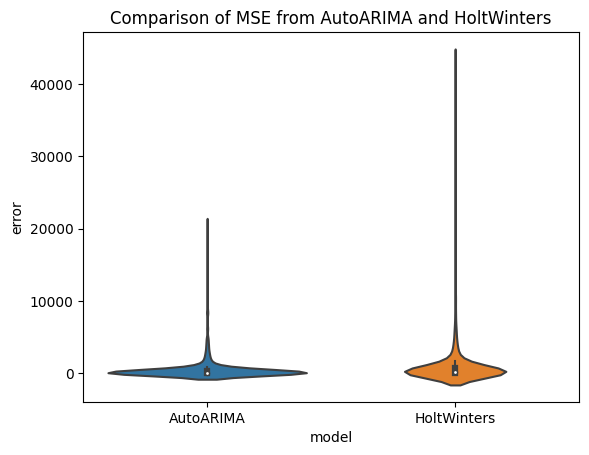

In [13]:
# compare mse between two models:

df_melted = evaluation_df[['AutoARIMA', 'HoltWinters']].melt(value_name='error', var_name='model')

sns.violinplot(data=df_melted, x='model', y='error')
plt.title("Comparison of MSE from AutoARIMA and HoltWinters")
plt.show()

In [14]:
# aggregate performance:

summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()

summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]
summary_df

,0
best_model,
HoltWinters,204
AutoARIMA,553


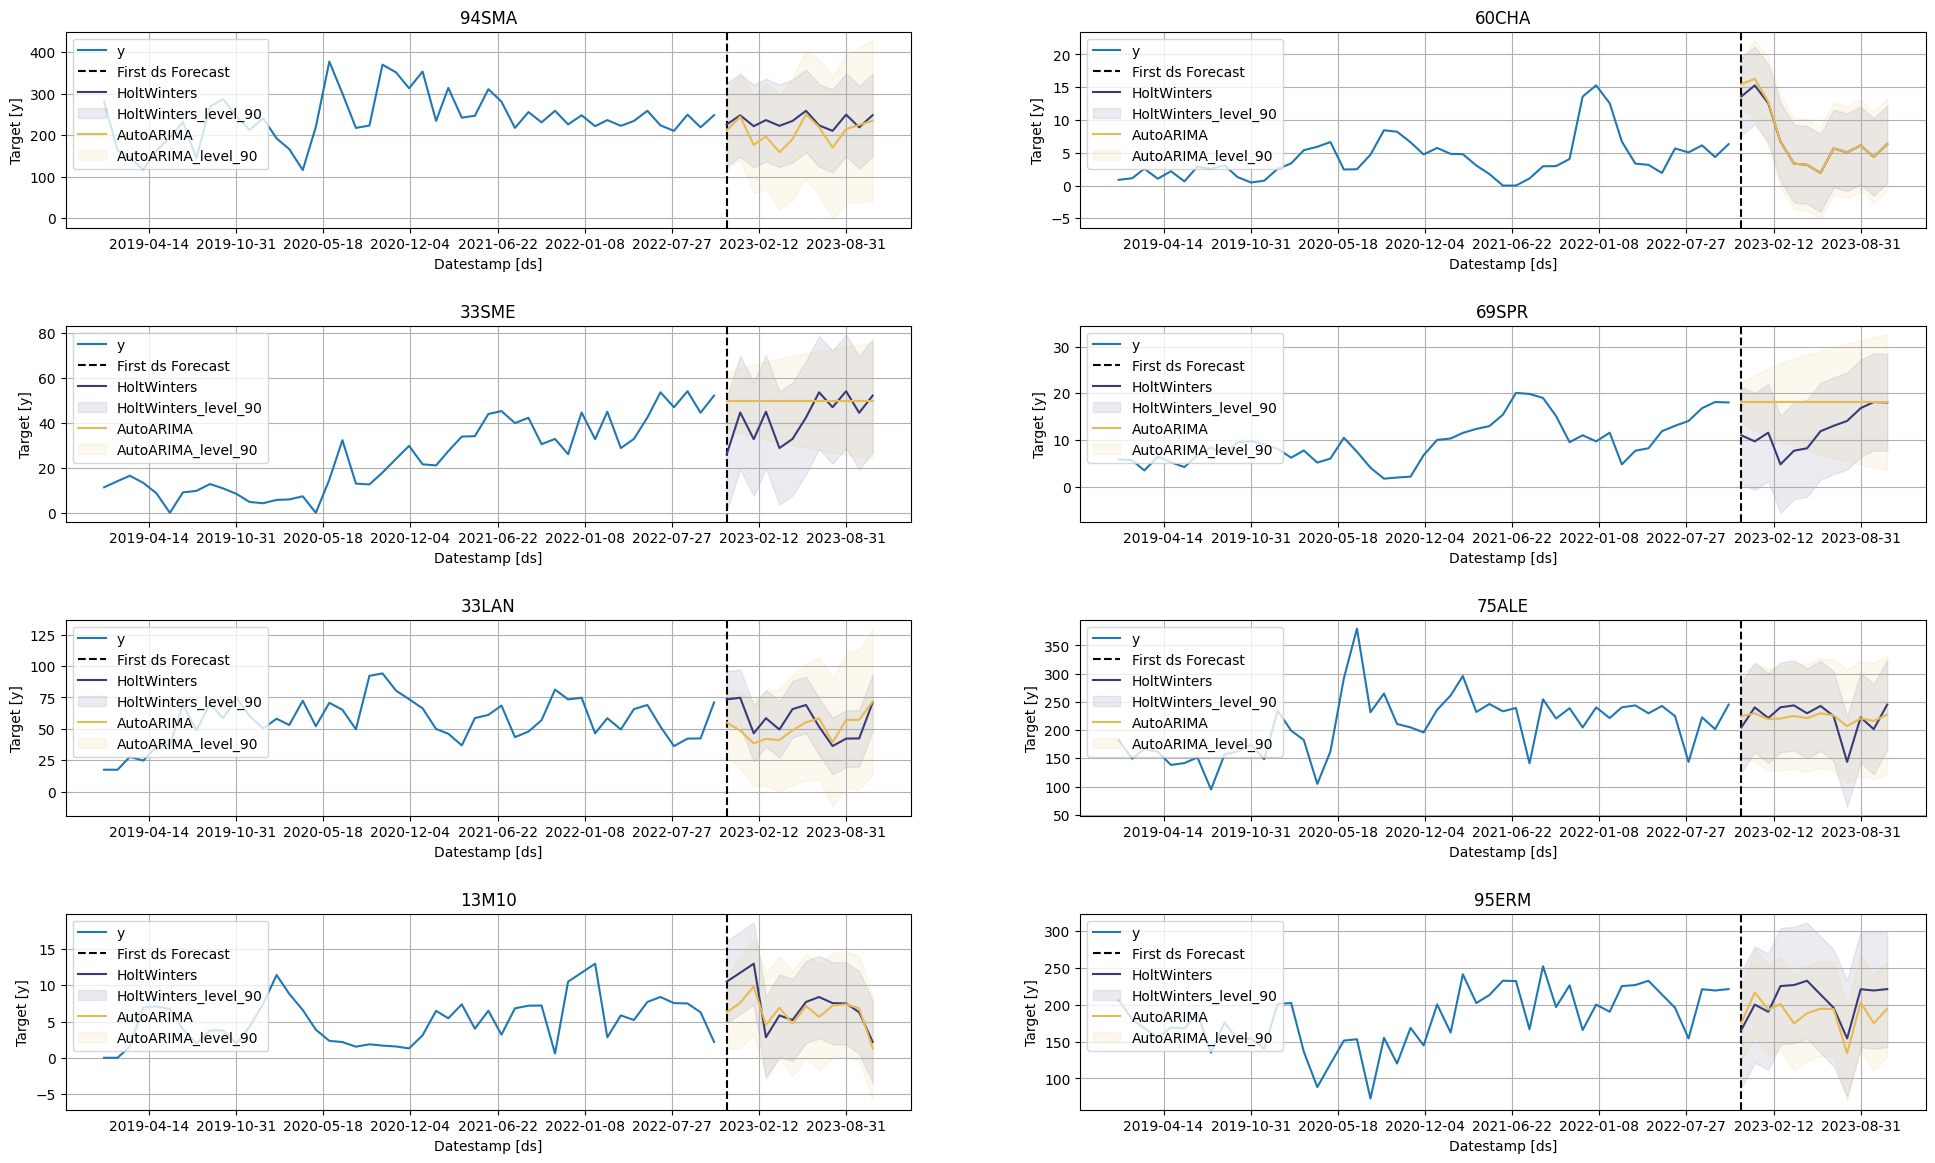

In [15]:
# find 8 IDs, where the best model is HoltWinters and see how the forecast looks compared to Arima:

seasonal_ids = evaluation_df.query('best_model == "HoltWinters"').index

sf.plot(df_nixtla,forecasts_df, unique_ids=seasonal_ids, models=["HoltWinters", "AutoARIMA"], engine='matplotlib')

In [16]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df

In [17]:
# find best model for each ID:

prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)

prod_forecasts_df.tail()

model,ds,best_model,best_model-hi-90,best_model-lo-90
unique_id,,,,
95TAV,2023-06-30,71.126411,105.524734,36.728088
95TAV,2023-07-31,54.782360,89.180687,20.384035
95TAV,2023-08-31,82.969078,117.367401,48.570755
95TAV,2023-09-30,82.014557,116.412880,47.616234
95TAV,2023-10-31,76.432022,110.830345,42.033699


/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


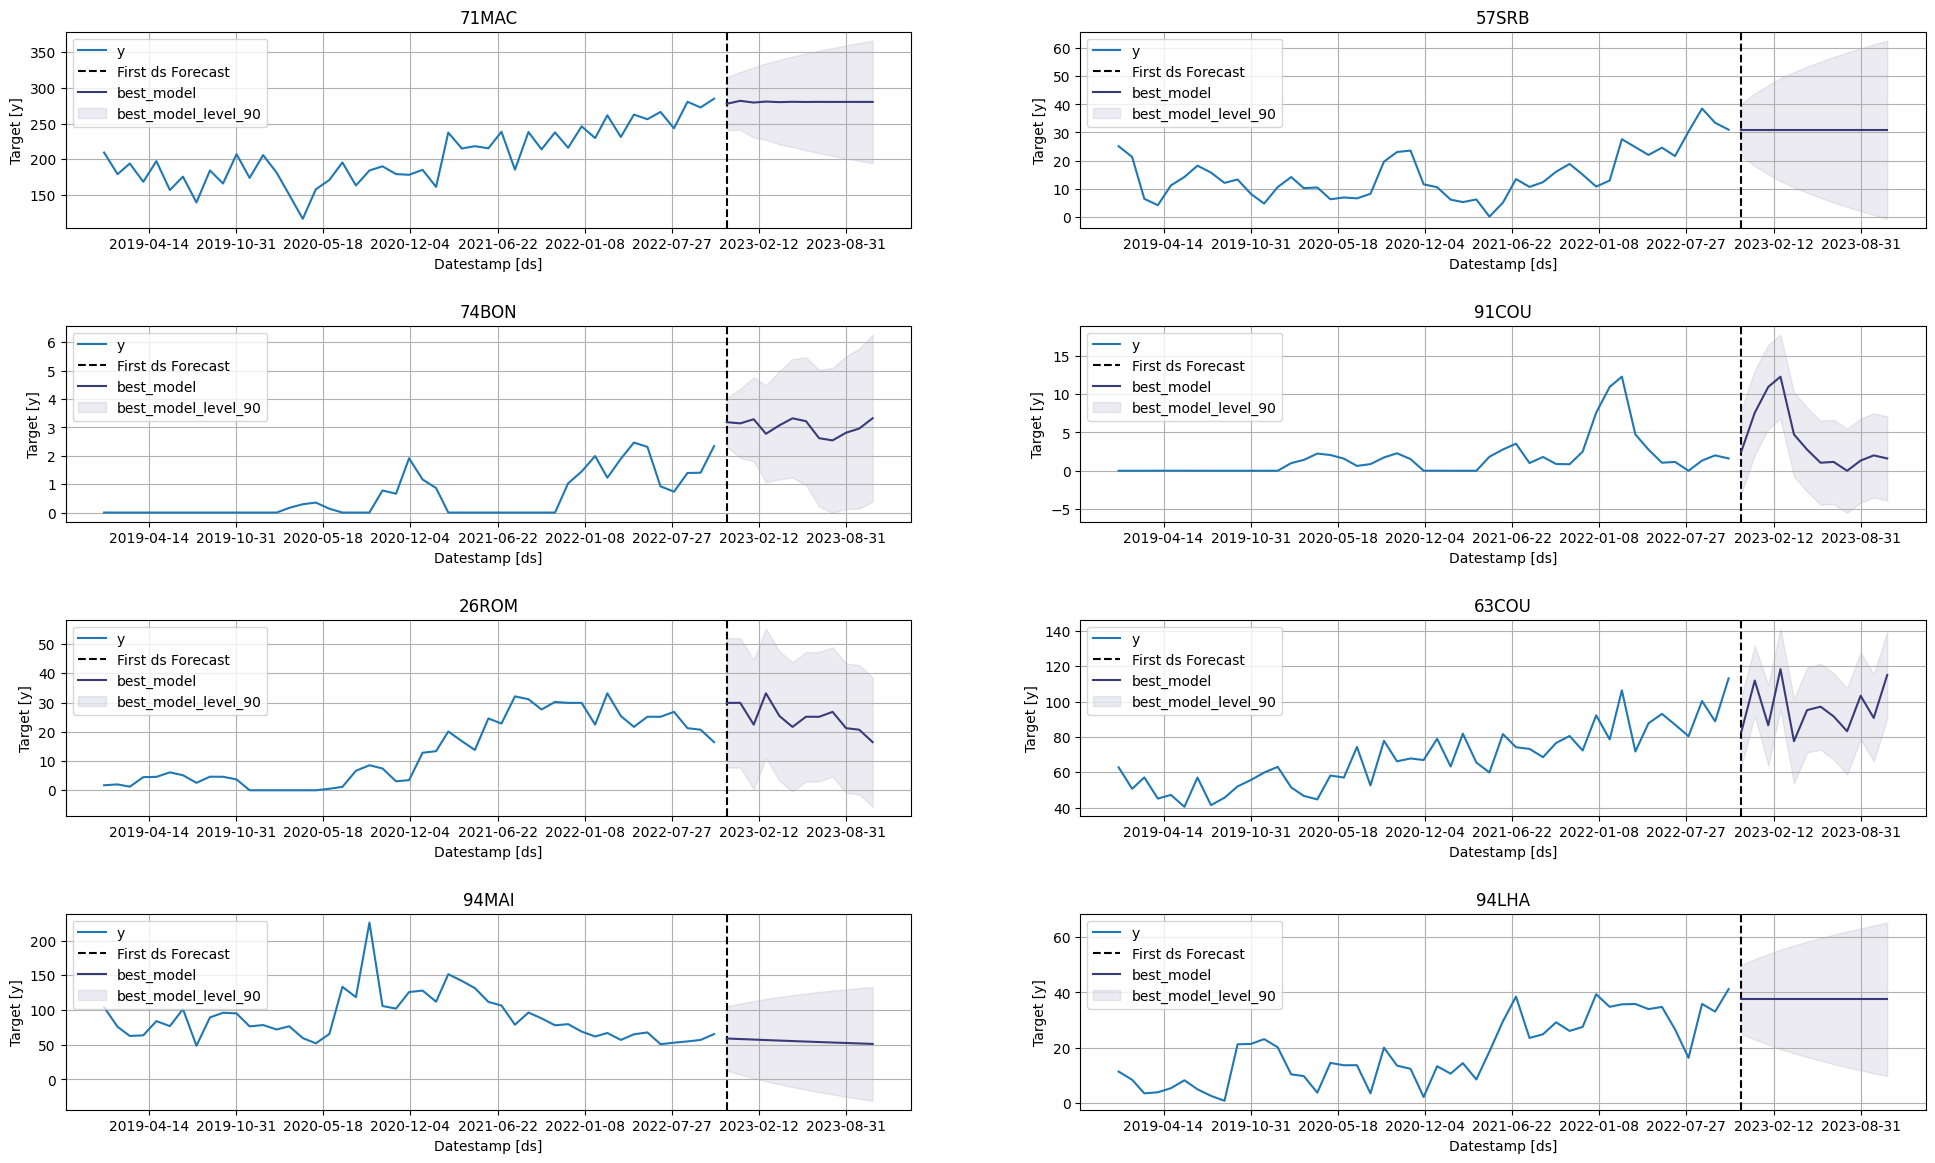

In [18]:
# plot 8 IDs with 90% CI, using the winning model for that series:

sf.plot(df_nixtla, prod_forecasts_df, level=[90], engine='matplotlib')